In [1]:
# Useful libraries
%reset -f
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import StratifiedKFold

In [2]:
seed_value= 2022

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(seed_value)

In [3]:
BASE_MODEL='RESNET101'
TYPE = 'SEUROP'
N_Fold = 3

In [4]:
if BASE_MODEL == 'MobileNet':
    from keras.applications.mobilenet_v2 import MobileNetV2 as BModel, preprocess_input, decode_predictions
    IMG_SIZE = (224,224,3)
elif BASE_MODEL == 'DenseNet121':
    from keras.applications.densenet import DenseNet121 as BModel, preprocess_input, decode_predictions
    IMG_SIZE = (224,224,3)
elif BASE_MODEL == 'VGG16':
    from keras.applications.vgg16 import VGG16 as BModel, preprocess_input, decode_predictions
    IMG_SIZE = (224,224,3)
elif BASE_MODEL == 'RESNET50':
    from keras.applications.resnet import ResNet50 as BModel, preprocess_input, decode_predictions
    IMG_SIZE = (224,224,3)
elif BASE_MODEL == 'RESNET50V2':
    from keras.applications.resnet_v2 import ResNet50V2 as BModel, preprocess_input, decode_predictions
    IMG_SIZE = (224,224,3)
elif BASE_MODEL == 'RESNET101':
    from keras.applications.resnet import ResNet101 as BModel, preprocess_input, decode_predictions
    IMG_SIZE = (224,224,3)
elif BASE_MODEL == 'RESNET101V2':
    from keras.applications.resnet_v2 import ResNet101V2 as BModel, preprocess_input, decode_predictions
    IMG_SIZE = (224,224,3) 
elif BASE_MODEL == 'RESNET152':
    from keras.applications.resnet import ResNet152 as BModel, preprocess_input, decode_predictions
    IMG_SIZE = (224,224,3)
elif BASE_MODEL == 'InceptionV3':
    from keras.applications.inception_v3 import InceptionV3 as BModel, preprocess_input, decode_predictions
    IMG_SIZE = (299, 299, 3)
elif BASE_MODEL == 'Xception':
    from keras.applications.xception import Xception as BModel, preprocess_input, decode_predictions
    IMG_SIZE = (299,299,3)
elif BASE_MODEL == 'DenseNet169': 
    from keras.applications.densenet import DenseNet169 as BModel, preprocess_input, decode_predictions
    IMG_SIZE = (224,224,3)
elif BASE_MODEL == 'DenseNet121':
    from keras.applications.densenet import DenseNet121 as BModel, preprocess_input, decode_predictions
    IMG_SIZE = (224,224,3)
elif BASE_MODEL == 'VGG19':
    from keras.applications.vgg19 import VGG19 as BModel, preprocess_input, decode_predictions
    IMG_SIZE = (224,224,3)
elif BASE_MODEL =='EfficientNetB0':
    from keras.applications.efficientnet import EfficientNetB0 as BModel, preprocess_input, decode_predictions
    IMG_SIZE = (224,224,3) 
elif BASE_MODEL == 'EfficientNetB1':
    from keras.applications.efficientnet import EfficientNetB1 as BModel, preprocess_input, decode_predictions
    IMG_SIZE = (240,240,3) 
elif BASE_MODEL == 'EfficientNetB2':
    from keras.applications.efficientnet import EfficientNetB2 as BModel, preprocess_input, decode_predictions
    IMG_SIZE = (260,260,3) 
elif BASE_MODEL == 'EfficientNetB3':
    from keras.applications.efficientnet import EfficientNetB3 as BModel, preprocess_input, decode_predictions
    IMG_SIZE = (300,300,3)
else:
    raise ValueError('Unknown model: {}'.format(BASE_MODEL))

In [5]:
# Function to read the images
def read_data(img_number_init, img_number_fin):
    # access to folder who contain the image of DOS
    path = 'DOS\\imagesCropees\\'
    # full path : 'C:\Users\Admin\Documents\projet_carcasses_Travail_brouillon\DOS\imagesCropees\' 'image' '2' '.jpg'
    img = path + 'image'+str(img_number_init)+'.jpg'
    img = image.load_img(img, target_size=IMG_SIZE)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    
    for i in range(img_number_init+1,img_number_fin+1):
        img = path+'image'+str(i)+'.jpg'
        img = image.load_img(img, target_size=IMG_SIZE)
        xx = image.img_to_array(img)
        xx = np.expand_dims(xx, axis=0)
        x = np.vstack([x, xx])
        
    return x

In [6]:
# Cleaning data
img_removed = [23, 43, 113, 153, 170, 187, 222, 230, 289, 316, 350, 395, 429, 483, 518, 541, 556, 566, 577, 652]
# NB : we need to remove the date cause "misunderstand" for the training procedures.
# Read data
nbr = len(img_removed)

X = read_data(3, img_removed[0]-1)

for i in range(nbr-1):
    X = np.vstack([X, read_data(img_removed[i]+1, img_removed[i+1]-1)])

df = pd.read_excel ('classification.xlsx', engine='openpyxl')
# transform categorical to numeric
df['Conf'].replace(['U','R','O','P'],[0, 1, 2, 3], inplace=True)

In [7]:
y_all = df['Conf']
y_all = np.array(y_all)

y = y_all[1:img_removed[0]-1]

for i in range(nbr-1):
    y = np.hstack([y, y_all[img_removed[i]:img_removed[i+1]-1]])
    

In [8]:
# Separation of data in train-validation-test with rate of 60%-20%-20%
from sklearn.model_selection import train_test_split

X = preprocess_input(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=2)


In [9]:
def create_model():
    
    # load the convolutional base model and set layers as not trainable
    base_model = BModel(include_top=False, input_shape=IMG_SIZE)

    for layer in base_model.layers:
        layer.trainable = False

    # add new classifier layers
    x = layers.Flatten()(base_model.layers[-1].output)
    x = layers.BatchNormalization()(x)

    x = layers.Dense(256, activation='relu', kernel_initializer='he_uniform')(x)
    x = layers.Dropout(0.55)(x)
    x = layers.BatchNormalization()(x)

    x = layers.Dense(128, activation='relu', kernel_initializer='he_uniform')(x)
    x = layers.Dropout(0.55)(x)
    x = layers.BatchNormalization()(x)

    output = layers.Dense(4, activation='softmax')(x)

    # define new model, compile and fit
    model = tensorflow.keras.Model(inputs=base_model.inputs, outputs=output)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [10]:
# store the trained models in a list
list_of_models = []
list_of_histories = []
count = 0

# we use k-Fold (i.e. we will build k models)
kfold = StratifiedKFold(n_splits=N_Fold, shuffle=True, random_state=2)

for train_index, val_index in kfold.split(X_train,y_train): 
    count = count + 1
    
    callbacks = [
        EarlyStopping(monitor = "val_accuracy",patience = 20),
        ModelCheckpoint(
        filepath = BASE_MODEL+'\\622'+TYPE+BASE_MODEL+str(count)+'.hdf5',
        monitor='val_accuracy',
        mode='max',
        save_best_only=True,
        verbose=1)
    ]
    
    model = create_model()
    
    # building the models
    history=model.fit(X_train[train_index],y_train[train_index],epochs=100, batch_size = 64,
                   callbacks=callbacks,
                   validation_data = (X_train[val_index],y_train[val_index]))
    list_of_models.append(model)
    list_of_histories.append(history)
    print('*************************')
    print('Training next model')
    print('*************************')

Epoch 1/100
6/6 [==============================] - 11s 707ms/step - loss: 1.8539 - accuracy: 0.2887 - val_loss: 15.9213 - val_accuracy: 0.3452

Epoch 00001: val_accuracy improved from -inf to 0.34524, saving model to RESNET101\622SEUROPRESNET1011.hdf5


C:\Users\tnngo1\Anaconda3\envs\GPU-2\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/100
6/6 [==============================] - 1s 240ms/step - loss: 1.4592 - accuracy: 0.3601 - val_loss: 6.6201 - val_accuracy: 0.3690

Epoch 00002: val_accuracy improved from 0.34524 to 0.36905, saving model to RESNET101\622SEUROPRESNET1011.hdf5
Epoch 3/100
6/6 [==============================] - 1s 241ms/step - loss: 1.2884 - accuracy: 0.4613 - val_loss: 4.0574 - val_accuracy: 0.4167

Epoch 00003: val_accuracy improved from 0.36905 to 0.41667, saving model to RESNET101\622SEUROPRESNET1011.hdf5
Epoch 4/100
6/6 [==============================] - 1s 244ms/step - loss: 1.0523 - accuracy: 0.5357 - val_loss: 3.0153 - val_accuracy: 0.4226

Epoch 00004: val_accuracy improved from 0.41667 to 0.42262, saving model to RESNET101\622SEUROPRESNET1011.hdf5
Epoch 5/100
6/6 [==============================] - 1s 240ms/step - loss: 1.0114 - accuracy: 0.6131 - val_loss: 2.2078 - val_accuracy: 0.4702

Epoch 00005: val_accuracy improved from 0.42262 to 0.47024, saving model to RESNET101\622SEUROPRESN

6/6 [==============================] - 1s 252ms/step - loss: 0.1886 - accuracy: 0.9435 - val_loss: 0.9481 - val_accuracy: 0.6548

Epoch 00024: val_accuracy did not improve from 0.66667
Epoch 25/100
6/6 [==============================] - 1s 251ms/step - loss: 0.1307 - accuracy: 0.9702 - val_loss: 0.9409 - val_accuracy: 0.6429

Epoch 00025: val_accuracy did not improve from 0.66667
Epoch 26/100
6/6 [==============================] - 1s 250ms/step - loss: 0.1483 - accuracy: 0.9702 - val_loss: 0.9354 - val_accuracy: 0.6488

Epoch 00026: val_accuracy did not improve from 0.66667
Epoch 27/100
6/6 [==============================] - 1s 252ms/step - loss: 0.1476 - accuracy: 0.9524 - val_loss: 0.9347 - val_accuracy: 0.6488

Epoch 00027: val_accuracy did not improve from 0.66667
Epoch 28/100
6/6 [==============================] - 1s 253ms/step - loss: 0.1256 - accuracy: 0.9613 - val_loss: 0.9283 - val_accuracy: 0.6607

Epoch 00028: val_accuracy did not improve from 0.66667
Epoch 29/100
6/6 [=====

6/6 [==============================] - 1s 250ms/step - loss: 1.0628 - accuracy: 0.6071 - val_loss: 1.9815 - val_accuracy: 0.5238

Epoch 00006: val_accuracy improved from 0.50000 to 0.52381, saving model to RESNET101\622SEUROPRESNET1013.hdf5
Epoch 7/100
6/6 [==============================] - 1s 251ms/step - loss: 0.7950 - accuracy: 0.6994 - val_loss: 1.7675 - val_accuracy: 0.5595

Epoch 00007: val_accuracy improved from 0.52381 to 0.55952, saving model to RESNET101\622SEUROPRESNET1013.hdf5
Epoch 8/100
6/6 [==============================] - 1s 252ms/step - loss: 0.7371 - accuracy: 0.6994 - val_loss: 1.6591 - val_accuracy: 0.5476

Epoch 00008: val_accuracy did not improve from 0.55952
Epoch 9/100
6/6 [==============================] - 1s 250ms/step - loss: 0.6567 - accuracy: 0.7589 - val_loss: 1.5843 - val_accuracy: 0.5476

Epoch 00009: val_accuracy did not improve from 0.55952
Epoch 10/100
6/6 [==============================] - 1s 250ms/step - loss: 0.5842 - accuracy: 0.8244 - val_loss: 


Epoch 00045: val_accuracy did not improve from 0.64286
Epoch 46/100
6/6 [==============================] - 1s 260ms/step - loss: 0.0793 - accuracy: 0.9851 - val_loss: 1.2209 - val_accuracy: 0.6488

Epoch 00046: val_accuracy improved from 0.64286 to 0.64881, saving model to RESNET101\622SEUROPRESNET1013.hdf5
Epoch 47/100
6/6 [==============================] - 1s 260ms/step - loss: 0.0680 - accuracy: 0.9881 - val_loss: 1.2164 - val_accuracy: 0.6548

Epoch 00047: val_accuracy improved from 0.64881 to 0.65476, saving model to RESNET101\622SEUROPRESNET1013.hdf5
Epoch 48/100
6/6 [==============================] - 1s 259ms/step - loss: 0.0667 - accuracy: 0.9851 - val_loss: 1.2436 - val_accuracy: 0.6131

Epoch 00048: val_accuracy did not improve from 0.65476
Epoch 49/100
6/6 [==============================] - 1s 256ms/step - loss: 0.0644 - accuracy: 0.9911 - val_loss: 1.3322 - val_accuracy: 0.5774

Epoch 00049: val_accuracy did not improve from 0.65476
Epoch 50/100
6/6 [======================

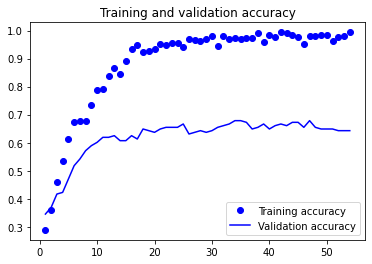

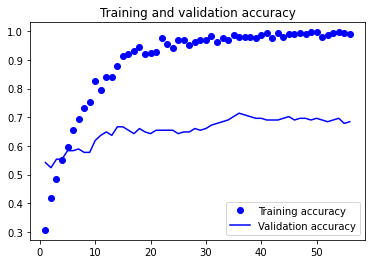

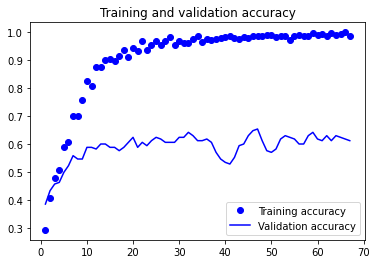

In [11]:
# Displaying curves of loss and accuracy during training
liste_precisions =[]

for i in range(N_Fold):
    acc = list_of_histories[i].history["accuracy"]
    val_acc = list_of_histories[i].history["val_accuracy"]
    loss = list_of_histories[i].history["loss"]
    val_loss = list_of_histories[i].history["val_loss"]
    epochs = range(1, len(acc) + 1)
    fig= plt.figure()
    plt.plot(epochs, acc, "bo", label="Training accuracy")
    plt.plot(epochs, val_acc, "b", label="Validation accuracy")
    plt.title("Training and validation accuracy")
    plt.legend()
    plt.show()

In [12]:
from tensorflow.keras.models import load_model

all_model=[]

for i in range(N_Fold):
    all_model.append(load_model(BASE_MODEL+'\\622'+TYPE+BASE_MODEL+str(i+1)+'.hdf5'))

In [13]:
with tf.device('/cpu:0'):

    model_predict_moyenne = all_model[0].predict(X_test)

    for i in range(1,N_Fold):
        model_predict_moyenne = model_predict_moyenne + all_model[i].predict(X_test)

    model_predict_moyenne = model_predict_moyenne/N_Fold

    # Calcul précision de méthode k_fold
    print(np.mean(np.argmax(model_predict_moyenne, axis = 1)==y_test))

0.7936507936507936


In [14]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [15]:
len(model.layers)

354